### LIBRERIAS

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, lfilter
from scipy import signal
import pandas as pd
from sklearn.cross_decomposition import CCA
from os import listdir
from os.path import isfile, join

### FUNCIONES

In [54]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def get_data(data, electrodes, freqs):
    all_electrodes = []
    one_electrode = []
    elecs = [int(electrodes_index[elec])-1 for elec in electrodes]
    for elec_index in elecs:
        for freq_index in np.arange(len(freqs)):
            freq_temp = stimulation[str(freqs[freq_index]) + ".0"]
            data_temp = data[elec_index,:,freq_temp,:]
            one_electrode.append(data_temp)
        all_electrodes.append(one_electrode)
        one_electrode = []
    return all_electrodes

def drop_trash_data(data, avoid_data):
    data_without_trash = []
    freq_temp = []
    data_temp = []
    for electrode_index in np.arange(len(data)):
        for frequency_index in np.arange(len(data[0])):
            temp2 = data[electrode_index][frequency_index]
            for block_index in np.arange(temp2.shape[1]):
                temp3 = temp2[:,block_index]
                temp3 = temp3[avoid_data:temp3.size-avoid_data:]
                data_temp.append(temp3)
            data_temp = np.array(data_temp).T
            freq_temp.append(data_temp)
            data_temp = []
        data_without_trash.append(freq_temp)
        freq_temp = []
    return data_without_trash

def normalization_data(data):
    data_normalized = []
    freq_temp = []
    data_temp = []
    for electrode_index in np.arange(len(data)):
        for frequency_index in np.arange(len(data[0])):
            temp2 = data[electrode_index][frequency_index]
            for block_index in np.arange(temp2.shape[1]):
                temp3 = temp2[:,block_index]
                temp3 = (temp3-np.min(temp3))/(np.max(temp3)-np.min(temp3))
                data_temp.append(temp3)
            data_temp = np.array(data_temp).T
            freq_temp.append(data_temp)
            data_temp = []
        data_normalized.append(freq_temp)
        freq_temp = []
    return data_normalized

def get_acc(data, reference_signals, stim_freq):
    cca = CCA(n_components=1)
    correctas = 0
    n_total = len(data)*len(data[0])*data[0][0].shape[1]
    for electrode_index in np.arange(len(data)):
        for frequency_index in np.arange(len(data[0])):
            temp = data[electrode_index][frequency_index]
            for block_index in np.arange(temp.shape[1]):
                temp2 = temp[:,block_index].reshape(-1,1)
                corr = []
                for reference_index in np.arange(len(reference_signals)):
                    reference_signal_temp = reference_signals[reference_index].reshape(-1,1)
                    cca.fit(temp2, reference_signal_temp)
                    a,b = cca.transform(temp2, reference_signal_temp)
                    x = abs(np.corrcoef(a[:,0], b)[0,1])
                    corr.append(x)
                corr = np.array(corr)
                if stim_freq[frequency_index] == stim_freq[np.argmax(corr)]:
                    correctas += 1
    return np.round((correctas/n_total)*100,1)
                



def BP_filter(data, freqs, fs, order=5):
    data_filtered = []
    freq_temp = []
    data_temp = []
    for electrode_index in np.arange(len(data)):
        for frequency_index in np.arange(len(data[0])):
            temp2 = data[electrode_index][frequency_index]
            for block_index in np.arange(temp2.shape[1]):
                temp3 = temp2[:,block_index]
                temp3 = bandpass_filter(temp3,freqs[frequency_index]-2, freqs[frequency_index]+2,fs,order=order)
                data_temp.append(temp3)
            data_temp = np.array(data_temp).T
            freq_temp.append(data_temp)
            data_temp = []
        data_filtered.append(freq_temp)
        freq_temp = []
    return data_filtered


def plot_one_fft(data, sr):
    x = fft(data)
    N = len(x)
    n = np.arange(N)
    sample_rate = sr
    T = N/sample_rate
    freq = n/T 
    n_oneside = N//2
    f_oneside = freq[:n_oneside]
    fig, ax = plt.subplots(figsize=(30,8))
    ax.plot(f_oneside, np.abs(x[:n_oneside]))
    ax.set_xticks(np.arange(min(f_oneside), max(f_oneside)+1, 2.0))
    ax.set_xlim([0,30])
    ax.grid()


### BASE DE DATOS DE SSVEP

In [3]:
DB_path = "../DB/"
DBfiles = [f for f in listdir(DB_path) if isfile(join(DB_path, f))]
DBfiles = DBfiles[2:]

### ELECTRODOS INDEX

In [4]:
#DICCIONARIO DE INDICES DE ELECTRODOS

def remove_whitespace(s):
    return s.strip()

df = pd.read_csv('../DB/electrodo_index.csv', header=None,sep='\t')
df[3] = df[3].astype(str)
df[3] = df[3].apply(remove_whitespace)
df[3] = df[3].replace('nan','PO5')
df[0] = df[0].replace('54      -144', '54')

electrode_name = np.array(df[3])
electrode_index = np.array(df[0])
electrodes_index = dict(zip(electrode_name,electrode_index))
electrodes_index

{'FP1': '1',
 'FPZ': '2',
 'FP2': '3',
 'AF3': '4',
 'AF4': '5',
 'F7': '6',
 'F5': '7',
 'F3': '8',
 'F1': '9',
 'FZ': '10',
 'F2': '11',
 'F4': '12',
 'F6': '13',
 'F8': '14',
 'FT7': '15',
 'FC5': '16',
 'FC3': '17',
 'FC1': '18',
 'FCz': '19',
 'FC2': '20',
 'FC4': '21',
 'FC6': '22',
 'FT8': '23',
 'T7': '24',
 'C5': '25',
 'C3': '26',
 'C1': '27',
 'Cz': '28',
 'C2': '29',
 'C4': '30',
 'C6': '31',
 'T8': '32',
 'M1': '33',
 'TP7': '34',
 'CP5': '35',
 'CP3': '36',
 'CP1': '37',
 'CPZ': '38',
 'CP2': '39',
 'CP4': '40',
 'CP6': '41',
 'TP8': '42',
 'M2': '43',
 'P7': '44',
 'P5': '45',
 'P3': '46',
 'P1': '47',
 'PZ': '48',
 'P2': '49',
 'P4': '50',
 'P6': '51',
 'P8': '52',
 'PO7': '53',
 'PO5': '54',
 'PO3': '55',
 'POz': '56',
 'PO4': '57',
 'PO6': '58',
 'PO8': '59',
 'CB1': '60',
 'O1': '61',
 'Oz': '62',
 'O2': '63',
 'CB2': '64'}

### FRECUENCIAS DE ESTIMULO

In [5]:
#DICCIONARIO DE LAS FRECUENCIAS DE ESTIMULACIONES

freqs = scipy.io.loadmat('../DB/Freq_Phase.mat')
freqs = freqs['freqs'][0,:].astype(str)
stimulation = dict(zip(freqs,np.arange(len(freqs))))
stimulation


{'8.0': 0,
 '9.0': 1,
 '10.0': 2,
 '11.0': 3,
 '12.0': 4,
 '13.0': 5,
 '14.0': 6,
 '15.0': 7,
 '8.2': 8,
 '9.2': 9,
 '10.2': 10,
 '11.2': 11,
 '12.200000000000001': 12,
 '13.200000000000001': 13,
 '14.200000000000001': 14,
 '15.200000000000001': 15,
 '8.4': 16,
 '9.4': 17,
 '10.4': 18,
 '11.4': 19,
 '12.4': 20,
 '13.4': 21,
 '14.4': 22,
 '15.4': 23,
 '8.6': 24,
 '9.6': 25,
 '10.6': 26,
 '11.6': 27,
 '12.600000000000001': 28,
 '13.600000000000001': 29,
 '14.600000000000001': 30,
 '15.600000000000001': 31,
 '8.8': 32,
 '9.8': 33,
 '10.8': 34,
 '11.8': 35,
 '12.8': 36,
 '13.8': 37,
 '14.8': 38,
 '15.8': 39}

### DATA(ELECTRODO, DATOS, FRECUENCIA, BLOQUE)

In [6]:
people = []

for index in np.arange(len(DBfiles)):
    temp = scipy.io.loadmat('../DB/'+DBfiles[index])
    people.append(np.array(temp['data']))

In [7]:
sr = 250
avoid_time = 0.5
trash_data = int(avoid_time*sr)

In [102]:
freqs = [8,10,12,14]
P4_OZ = get_data(people[7],['O1','Oz','O2'],freqs)

### NORMALIZACION Y ELIMINACION DE DATO BASURA

In [103]:
P4_CLEAN = drop_trash_data(P4_OZ,trash_data)

P4_CLEAN_NORM = normalization_data(P4_CLEAN)

### FILTRADO

In [104]:
freqs = [8,10,12,14]
P4_CLEAN_F = BP_filter(P4_CLEAN_NORM,freqs,sr,5)

### PLOT FRECUENCIA

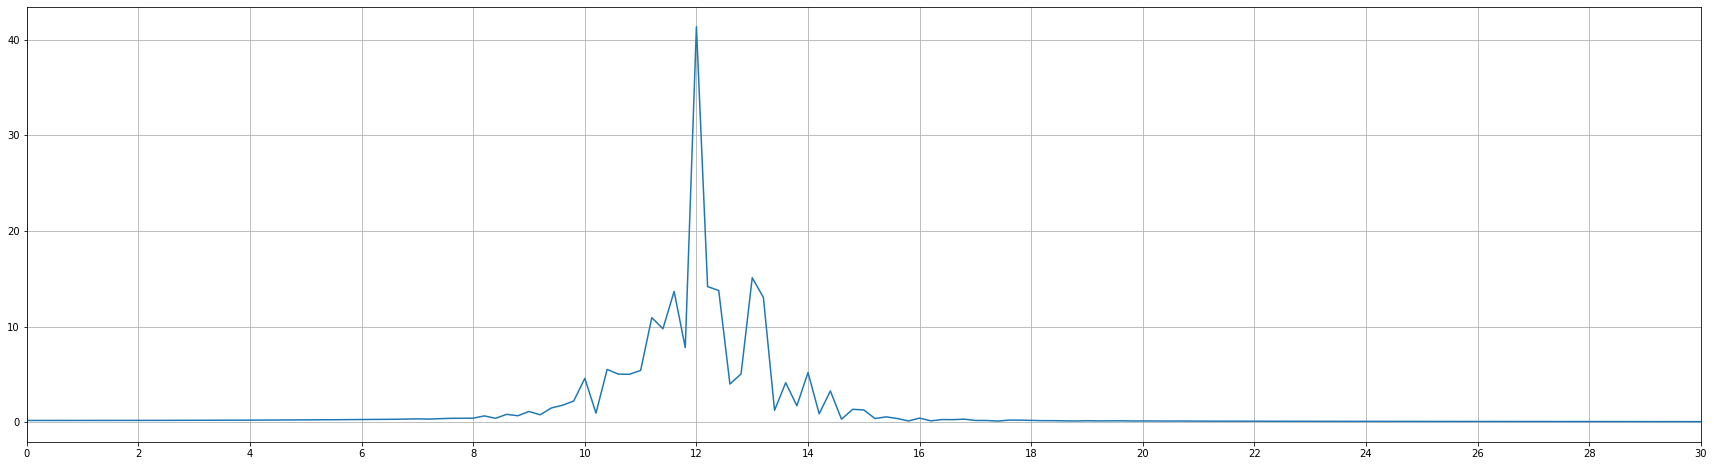

In [105]:
plot_one_fft(P4_CLEAN_F[1][2][:,5],sr)

### CREACION DE SEÑALES DE REFERENCIA

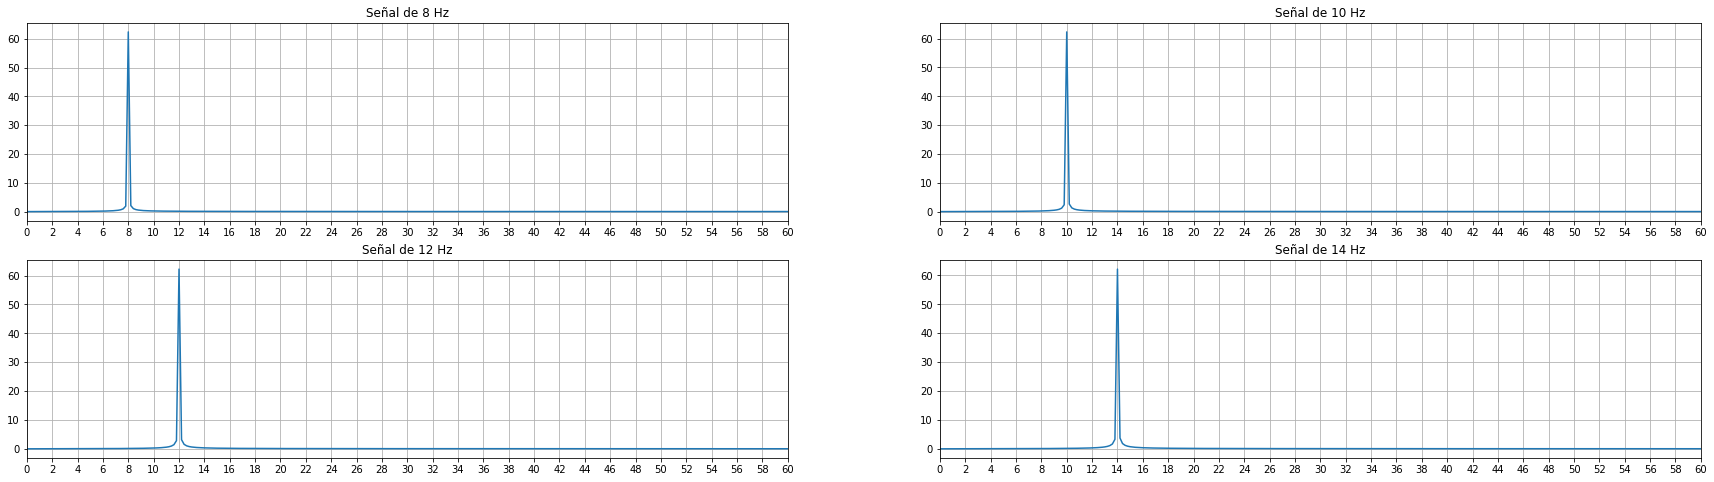

In [106]:
a1 = 0.1
a2 = 0

#FRECUENCIA DE LAS SEÑALES
target_freqs = [8,10,12,14]

reference_signals = []
reference_ffts = []

max_time = len(P4_CLEAN_F[0][0][:,0])/sr
time_steps = np.linspace(0, max_time, len(P4_CLEAN_F[0][0][:,0]))


for index in np.arange(len(target_freqs)):
    model_signal = a1*np.sin(np.pi*2*time_steps*target_freqs[index]) + a2*np.sin(np.pi*4*time_steps*target_freqs[index])
    #model_signal = (model_signal-np.min(model_signal))/(np.max(model_signal)-np.min(model_signal))
    reference_signals.append(model_signal)
    reference_ffts.append(fft(model_signal))

N = len(reference_ffts[0])
n = np.arange(N)
T = N/sr
freq = n/T 
n_oneside = N//2
f_oneside = freq[:n_oneside]

fig, ax = plt.subplots(2,2,figsize=(30,8))

for i in np.arange(len(target_freqs)):
    if i<2:
        ax[0,i].plot(f_oneside, np.abs(reference_ffts[i][:n_oneside]))
        ax[0,i].set_title(f'Señal de {str(target_freqs[i])} Hz')
        ax[0,i].set_xticks(np.arange(min(f_oneside), max(f_oneside)+1, 2.0))
        ax[0,i].set_xlim([0,60])
        ax[0,i].grid()
    else:
        ax[1,i-2].plot(f_oneside, np.abs(reference_ffts[i][:n_oneside]))
        ax[1,i-2].set_title(f'Señal de {str(target_freqs[i])} Hz')
        ax[1,i-2].set_xticks(np.arange(min(f_oneside), max(f_oneside)+1, 2.0))
        ax[1,i-2].set_xlim([0,60])
        ax[1,i-2].grid()

plt.show()

### ALGORITMO CCA

In [107]:
stim_freq = [8,10,12,14]
acc = get_acc(P4_CLEAN_F,reference_signals=reference_signals,stim_freq=stim_freq)
acc

93.1